# Сборный проект. Анализ рынка компьютерных игр.

**Задача: выявить определяющие успешность игры закономерности.** Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
tips = sns.load_dataset("tips")
from scipy import stats as st

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [3]:
# заменим тип данных, на корректный
df['year_of_release'] = pd.to_numeric(df['year_of_release'], downcast='integer', errors='coerce')
# также одновременно с заменой, с помощью функции to_numeric избавимся от значения 'tbd' в рейтинге пользователей
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce') 

In [4]:
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
# посмотрим на пропуски в названии
print(df[df['name'].isnull()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN  


In [6]:
# в строках с пропущенным названием отсутствует также и жанр игры, поэтому можно их отбросить, 
# т.к. данные строки не информативны
df.dropna(subset = ['name'], inplace = True)

In [7]:
# посмотрим можно ли достать год релиза из названия
df.query('year_of_release in "NaN"')['name'].unique()

array(['Madden NFL 2004', 'FIFA Soccer 2004',
       'LEGO Batman: The Videogame', 'wwe Smackdown vs. Raw 2006',
       'Space Invaders', 'Rock Band',
       "Frogger's Adventures: Temple of the Frog",
       'LEGO Indiana Jones: The Original Adventures', 'Call of Duty 3',
       'Call of Duty: Black Ops', 'Triple Play 99', 'Adventure', 'Combat',
       'LEGO Harry Potter: Years 5-7', 'NASCAR Thunder 2003',
       'Hitman 2: Silent Assassin', 'Legacy of Kain: Soul Reaver',
       'Donkey Kong Land III', 'Air-Sea Battle', 'Suikoden III',
       'Wheel of Fortune', 'Yakuza 4', 'Namco Museum', 'Rhythm Heaven',
       'The Lord of the Rings: War in the North', 'Madden NFL 07',
       'MLB SlugFest 20-03', 'Shaun White Snowboarding',
       'PES 2009: Pro Evolution Soccer', 'WarioWare: Twisted!',
       'Madden NFL 11', 'Test Drive Unlimited 2',
       'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
       'Monster Hunter 2', 'Metal Gear Solid 2: Substance',
       'Advanc

In [8]:
# выделяем год релиза
df['year_name'] = df['name'].str.extract('(19\d{2}|20\d{2})').fillna(0).astype('int')

In [9]:
# проверим совпадает ли дата из названия игры с датой релиза
df.query('year_name > 1970 & year_name <= 2016').pivot_table(index=['name', 'year_name'],\
                                values='year_of_release', aggfunc=['max', 'min']).sort_values('year_name').head(10)

,,max,min
,,year_of_release,year_of_release
name,year_name,,
Olympic Soccer: Atlanta 1996,1996,1996.0,1996.0
Olympic Summer Games: Atlanta 1996,1996,1996.0,1996.0
Gekikuukan Pro Yakyuu: At the End of the Century 1999,1999,2000.0,2000.0
The King of Fighters: Dream Match 1999,1999,1999.0,1999.0
WWF WrestleMania 2000,2000,1999.0,1999.0
J-League Jikkyou Winning Eleven 2000,2000,2000.0,2000.0
Madden NFL 2000,2000,1999.0,1998.0
NHL 2000,2000,1998.0,1998.0


In [10]:
#смотрим кол-во пропусков до обработки
df['year_of_release'].isnull().sum()

269

In [11]:
# заменим пропуски ограничив года из названия периодом с 1970 по 2016 гг
year_list = df.query('year_name > 1970 & year_name <= 2016 & year_of_release in "NaN"')['name'].unique()
for i in year_list:
    df.loc[df['name'] == i, 'year_of_release'] = df.loc[df['name'] == i, 'year_of_release'].fillna(df['year_name'])

In [12]:
df['year_of_release'].isnull().sum() # смотрим результат замены

252

В остальных случаях заменим пропуск на условное значение 0, для удобства.

In [13]:
df['year_of_release'] = df['year_of_release'].fillna(0).astype('int')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
year_name          16713 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.3+ MB


Пропуски в рейтингах пользователей и критиков можно заполнить средним рейтингом игры по всем платформам, на которых она представлена. А в случае с рейтингом ESRB - по одному из заполненных значений на платформах.

In [15]:
# отберем топ-10 игр по количеству платформ, на которых они представлены
dict = df.pivot_table(index='name', values='platform', aggfunc='count').sort_values('platform', ascending=False).head(10)

In [16]:
# посмотрим как отличается рейтинг между платформами
df.query('name in @dict.index')\
    .pivot_table(index='name', columns='platform', values='critic_score', aggfunc='median', margins=True)

platform,3DS,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,Wii,WiiU,X360,XB,XOne,All
name,,,,,,,,,,,,,,,
FIFA 14,NaN,NaN,NaN,NaN,87.0,NaN,86.0,87.0,NaN,NaN,NaN,84.0,NaN,88.0,87.0
FIFA 15,NaN,NaN,NaN,NaN,82.0,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,82.0,82.0
LEGO Jurassic World,NaN,NaN,NaN,NaN,72.0,NaN,NaN,70.0,NaN,NaN,71.0,NaN,NaN,70.0,70.5
LEGO Marvel Super Heroes,61.0,NaN,NaN,NaN,78.0,NaN,82.0,83.0,NaN,NaN,82.0,80.0,NaN,NaN,81.0
LEGO The Hobbit,NaN,NaN,NaN,NaN,68.0,NaN,NaN,72.0,NaN,NaN,NaN,70.0,NaN,69.0,69.5
Madden NFL 07,NaN,70.0,68.0,82.0,NaN,84.0,76.0,NaN,78.0,81.0,NaN,80.0,83.0,NaN,80.0
Madden NFL 08,NaN,71.0,NaN,75.0,NaN,78.0,81.0,NaN,75.0,76.0,NaN,85.0,76.0,NaN,76.0
Monopoly,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,70.0,NaN,56.0,NaN,NaN,56.0
Need for Speed: Most Wanted,NaN,45.0,NaN,80.0,82.0,82.0,NaN,NaN,NaN,NaN,NaN,83.0,83.0,NaN,82.0


In [17]:
#df.query('name == "Need for Speed: Most Wanted"')

In [18]:
# заменим пропуски в рейтинге критиков
names = df['name'].unique()
for i in names:
    median = df.loc[(df['name'] == i)&(~pd.isnull(df['critic_score'])), 'critic_score'].median()
    df.loc[df['name'] == i, 'critic_score'] = df.loc[df['name'] == i, 'critic_score'].fillna(median)

In [19]:
# сделаем аналогичную замену для рейтинга пользователей
for i in names:
    median = df.loc[(df['name'] == i)&(~pd.isnull(df['user_score'])), 'user_score'].median()
    df.loc[df['name'] == i, 'user_score'] = df.loc[df['name'] == i, 'user_score'].fillna(median)

In [20]:
# так как рейтинг ESRB вряд ли должен отличаться на разных платформах, вытащим одно из значений для замены
for i in names:
    max = df.loc[(df['name'] == i)&(~pd.isnull(df['rating'])), 'rating'].max()
    df.loc[df['name'] == i, 'rating'] = df.loc[df['name'] == i, 'rating'].fillna(max)

In [21]:
# считаем общие продажи
df['all_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9098 non-null float64
user_score         8689 non-null float64
rating             10386 non-null object
year_name          16713 non-null int64
all_sales          16713 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 2.4+ MB


В остальных случаях оставим пропуски как есть, т.к. объективных данных для замены недостаточно.

# Анализ данных

#### 1. Продажи по годам, срок жизни платформы
- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

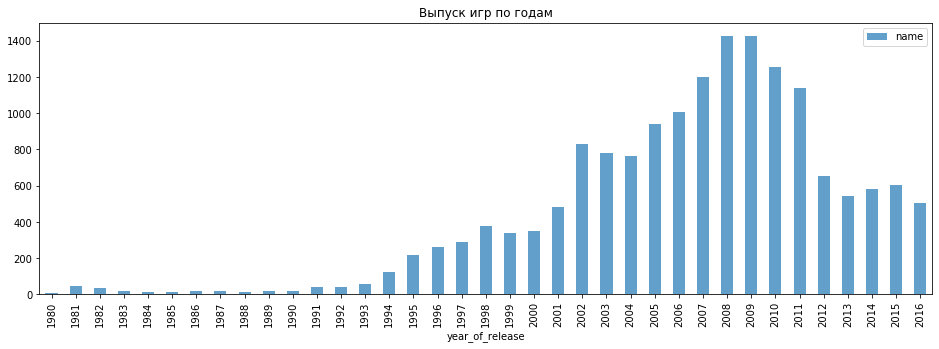

In [23]:
# Построим распределение игр по годам
df.query('year_of_release != 0')\
    .pivot_table(index='year_of_release', values='name', aggfunc='count')\
    .plot(kind='bar', figsize=(16,5), alpha=0.7, title='Выпуск игр по годам')

Очевидно, что "золотое время" видеоигр было в период с 2002 по 2011гг. Нам же для дальнейшего исследования лучше ограничить период более актуальными данными, например взять средний срок жизни платформы. Определим его как разность между самой ранней и поздней датой выпуска игры на платформе и рассчитаем среднее значение.

In [24]:
# Посмотрим топ-10 платформ по выручке
df.query('year_of_release != 0').pivot_table(index='platform', values='all_sales', aggfunc='sum')\
                                .sort_values('all_sales', ascending=False).head(10)

,all_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


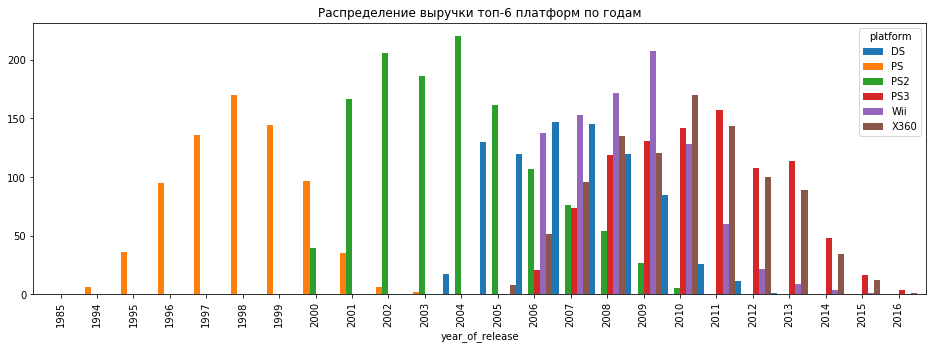

In [25]:
# для того, чтобы посмотреть распределение выручки возьмем платформы с общей выручкой от 700 млн.$
top_plfrm = df.query('year_of_release != 0').pivot_table(index='platform', values='all_sales', aggfunc='sum')\
                                .sort_values('all_sales', ascending=False).head(6)

df.query('platform in @top_plfrm.index & year_of_release > 0')\
    .pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')\
    .plot(kind='bar', figsize = (16,5), width=1, title="Распределение выручки топ-6 платформ по годам")

По графику видно, что срок жизни крупных платформ составляет ~10 лет.

In [26]:
# Посмотрим также срок жизни по всем платформам
pl_life = df.query('year_of_release != 0').pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
pl_life.columns = ['min', 'max']
pl_life['lifetime'] = pl_life['max']-pl_life['min']+1 # добавляем 1, т.к. нужно посчитать крайние года включительно
pl_life['lifetime'].describe()

count    31.000000
mean      8.612903
std       6.998464
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      32.000000
Name: lifetime, dtype: float64

Eсли брать во внимание всех игроков рынка, то средний срок жизни сокращается до ~ 8 с половиной лет.

#### 2. Актуальный период
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.

Нам требуется построить прогноз на краткосрочный период - 1год, поэтому 8-10 лет будет в данном случе слишком много. Также надо отметить, что в последние 5 лет тенденция на рынке сильно изменилась, объем выпускаемых игр сократился почти вдвое и держится на этом уровне. Поэтому за актуальный период мы возьмем **последние 5 лет**. 

#### 3. Потенциально прибыльные платформы
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Потенциально выгодные платформы можно определить по следующим признакам:
    - общая сумма продаж с платформы
    - динамика продаж последних лет
    - текущий возраст платформы

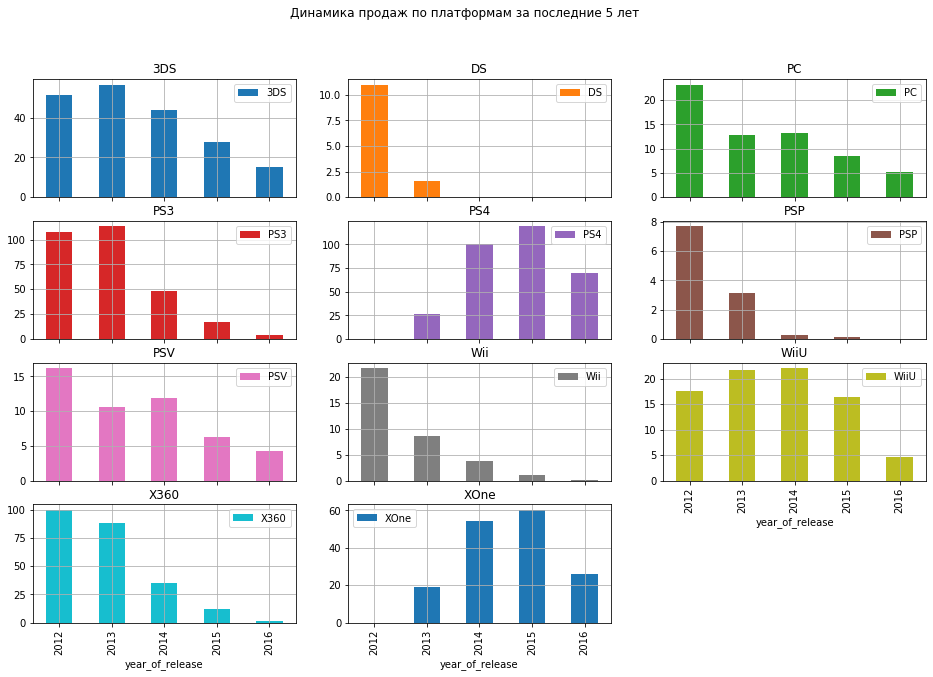

In [27]:
# посмотрим динамику продаж за последние 5 лет(выбранный актуальный период)
df.query('year_of_release > 2011')\
    .pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')\
    .plot(kind='bar', subplots=True, grid=True, title="Динамика продаж по платформам за последние 5 лет",
        layout=(4, 3), sharex=True, sharey=False, legend=True, figsize=(16,10))
plt.show()

In [28]:
# рассчитаем продажи за актуальный период
top_actual = df.query('year_of_release > 2011').pivot_table(index='platform', values=['all_sales'], aggfunc=['sum'])
top_actual.columns = ['sales']
# добавим полный срок жизни платформы
top_actual = pd.merge(top_actual, pl_life, on='platform') 
top_actual.sort_values('sales', ascending=False)

,sales,min,max,lifetime
platform,,,,
PS4,314.14,2013,2016,4
PS3,288.79,2006,2016,11
X360,236.54,2005,2016,12
3DS,194.61,2011,2016,6
XOne,159.32,2013,2016,4
WiiU,82.19,2012,2016,5
PC,63.00,1985,2016,32
PSV,49.18,2011,2016,6
Wii,35.37,2006,2016,11


За выбранный период стабильный рост показывают только 2 "молодые" платформы:
    - PS4, которая также является лидером по объему выручки
    - и платформа XOne
По остальным игрокам рынка можно заметить тренд на снижение выручки.

#### 4. Разница в продажах
- Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

In [29]:
df_actual = df.query('year_of_release > 2011') # оставим данные только за актуальный период

(0, 2)

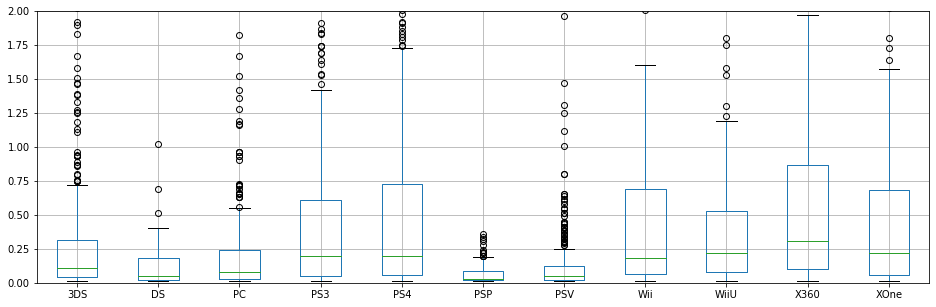

In [30]:
plt.figure(figsize=(16,5))
df_actual.pivot_table(index='name', columns='platform', values = 'all_sales', aggfunc='sum').boxplot()
plt.ylim(0, 2)

In [31]:
games = df_actual.pivot_table(index='platform', values = 'all_sales', aggfunc=['count', 'mean', 'sum'])
games.columns = ['count', 'mean_sales', 'total_sales']
games.sort_values('mean_sales', ascending=False)

,count,mean_sales,total_sales
platform,,,
X360,292,0.810068,236.54
PS4,392,0.801378,314.14
Wii,54,0.655000,35.37
XOne,247,0.645020,159.32
PS3,493,0.585781,288.79
WiiU,147,0.559116,82.19
3DS,396,0.491439,194.61
DS,31,0.404839,12.55
PC,251,0.250996,63.00


Итого можно сделать вывод, что платформа PS4 уступает в средней выручке только 1 платформе X360, но за счет большего числа предлагаемых игр опережает по общей выручке всех конкурентов. Вторая выбранная нами платформа XOne сильно уступает им в выручке прмерно на 150 тыс.долл.

#### 5. Корреляция между отзывами и продажами
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.

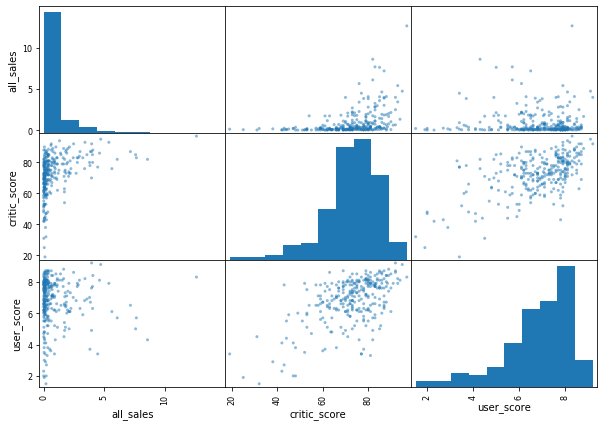

In [32]:
# для того, чтобы посмотреть корреляцию возьмем платформу PS4
pd.plotting.scatter_matrix(df_actual.query('platform == "PS4"')\
                           [['all_sales', 'critic_score', 'user_score']], figsize=(10, 7), alpha=0.5)
plt.show()

In [33]:
df_actual.query('platform == "PS4"')[['all_sales', 'critic_score', 'user_score']].corr()

,all_sales,critic_score,user_score
all_sales,1.000000,0.390890,-0.020862
critic_score,0.390890,1.000000,0.570418
user_score,-0.020862,0.570418,1.000000


In [34]:
df_actual.query('platform != "PS4"')[['all_sales', 'critic_score', 'user_score']].corr()

,all_sales,critic_score,user_score
all_sales,1.000000,0.269093,0.016809
critic_score,0.269093,1.000000,0.441288
user_score,0.016809,0.441288,1.000000


Можно отметить, что связи продаж с рейтингом пользователей почти нет, коэффицент корреляции близок к нулю.
А вот связь с рейтингом критиков более явная, чем выше рейтинг, тем больше сумма продаж по игре. Аналогичная тенденция прослеживается и на других платформах.

#### 6. Распределение игр по жанрам
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Text(0.5, 1.0, 'Суммы продаж по жанрам')

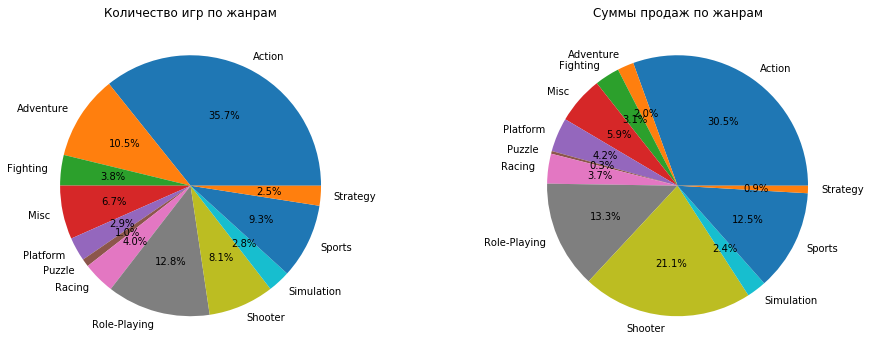

In [35]:
# построим круговые диаграммы, чтобы посмотреть распределение по количеству и суммам продаж
genre_cnt = df_actual.groupby('genre')['all_sales'].count()
genre_sum = df_actual.groupby('genre')['all_sales'].sum()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.pie(genre_cnt, autopct='%.1f%%', labels=genre_cnt.index)
ax1.set_title('Количество игр по жанрам')

ax2.pie(genre_sum, autopct='%.1f%%', labels=genre_cnt.index)
ax2.set_title('Суммы продаж по жанрам')

По количеству предлагаемых игр лидерами являются жанры: Action, Role-Playing, Adventure. Тем не менее по продажам жанр Adventure находтится на одном из последних мест. А топ-3 жанра по продажам это Action, Shooter и Role-Playing.
Меньше всего представлено игр жанров Strategy и Puzzle, и данные жанры также приносят меньше всего выручки.

# Портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?



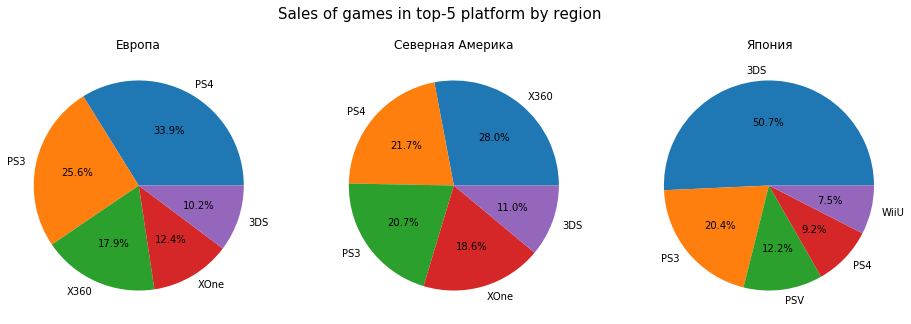

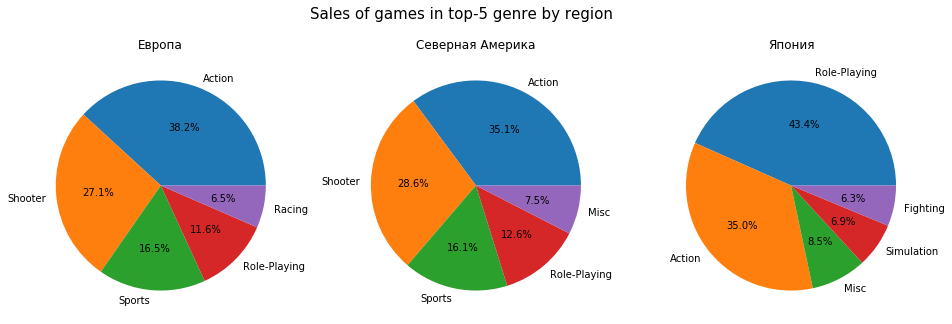

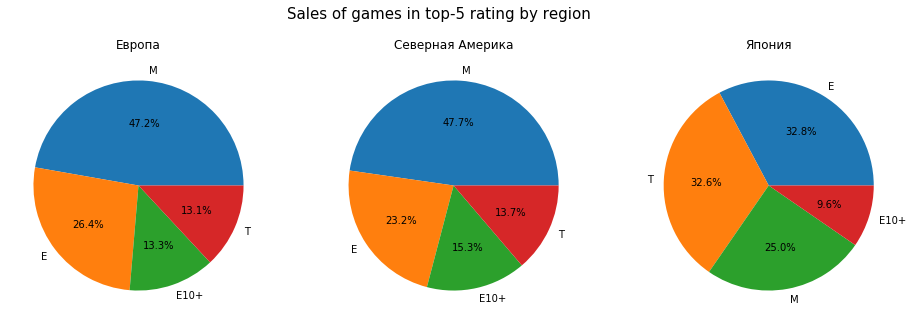

In [36]:
# построим графики распределения продаж в топ-5 каждой метрики(платформа, жанр, рейтинг ESRB) 
metrix = ['platform', 'genre', 'rating']
for name in metrix:
    top_eu = df_actual.groupby(name)['eu_sales'].sum().sort_values(ascending=False).head()
    top_na = df_actual.groupby(name)['na_sales'].sum().sort_values(ascending=False).head()
    top_jp = df_actual.groupby(name)['jp_sales'].sum().sort_values(ascending=False).head()

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.suptitle('Sales of games in top-5 '+ name +' by region', y = 1, fontsize = 15)

    ax1.pie(top_eu, autopct='%.1f%%', labels=top_eu.index)
    ax1.set_title('Европа')

    ax2.pie(top_na, autopct='%.1f%%', labels=top_na.index)
    ax2.set_title('Северная Америка')

    ax3.pie(top_jp, autopct='%.1f%%', labels=top_jp.index)
    ax3.set_title('Япония')

**Платформы**

Распределение продаж по платформам в Европе и Северной Америке довольно схоже, за исключением того, что в Америке платформа XOne пользуется большей популярностью, а вот в Японии данная платформа даже не попала в ТОП. Абсолютный лидер Японии - это платформа 3DS, хотя в Европе и Америке она представлена довольно скромно.

**Жанры**

Жанр Action - одинаково популярен во всех трех регионах, в Европе и Америке он занимает 1 место в рейтинге, а вот в Японии самый популярный жанр - это Role-Playing. Второй по популярности в Европе и Америке жанр Shooter в Японии в топ-5 не попал.

**Рейтинг ESRB (Возрастная категория)**

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех» or K-A - ("Kids to Adults")
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»

В Европе и Америке распределение по позрастным категориям почти идентично, большая часть продаж приходится на игры категории М(для взрослых). В Японии два лидера рейтинга Т(для подростков) и Е(для всех) имеют почти одинаковые доли. А вот игры для взрослых в Японии находятся лишь на 3-м месте.

# Проверка гипотез
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

Обе гипотезы двусторонние и в целом их можно сформулировать как: средние двух генеральных совокупностей равны между собой. В обоих случаях примем критический уровень статистической значимости равным 0,05.

**I. Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые**.

Нулевая гипотеза: *средние рейтинги платформ Xbox One и PC равны*

Альтернативная гипотеза: *средние рейтинги платформ Xbox One и PC не равны*

In [37]:
# Посмотрим на значения рейтинга
print(df_actual.query('user_score not in "NaN" & platform in ("XOne", "PC")').pivot_table(index='platform', values='user_score'))
print()

alpha = .05

results = st.ttest_ind(
    df_actual.query('user_score not in "NaN" & platform == "XOne"')['user_score'], 
    df_actual.query('user_score not in "NaN" & platform == "PC"')['user_score']) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

          user_score
platform            
PC          6.443365
XOne        6.617233

p-значение: 0.24783797375476932
Не получилось отвергнуть нулевую гипотезу


In [38]:
import numpy as np
variance1 = np.var(df_actual.query('user_score not in "NaN" & platform == "XOne"')['user_score'], ddof=1)
print('Дисперсия выборки 1 равна: {:.0f}'.format(variance1))

variance2 = np.var(df_actual.query('user_score not in "NaN" & platform == "PC"')['user_score'], ddof=1)
print('Дисперсия выборки 2 равна: {:.0f}'.format(variance2))

Дисперсия выборки 1 равна: 2
Дисперсия выборки 2 равна: 3


Исходя из полученного результата, можно сделать вывод, что рейтинги равны между собой.

**II. Проверим гипотезу о том, что cредние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные**.

Нулевая гипотеза: *средние рейтинги жанров Action и Sports равны*

Альтернативная гипотеза: *средние рейтинги жанров Action и Sports не равны*

In [39]:
# Посмотрим на значения рейтинга
print(df_actual.query('user_score not in "NaN" & genre in ("Action", "Sports")').pivot_table(index='genre', values='user_score'))
print()

alpha = .05

results = st.ttest_ind(
    df_actual.query('user_score not in "NaN" & genre == "Action"')['user_score'], 
    df_actual.query('user_score not in "NaN" & genre == "Sports"')['user_score']) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

        user_score
genre             
Action    6.863228
Sports    5.413348

p-значение: 3.9597927013302285e-33
Отвергаем нулевую гипотезу


А вот рейтинг жанра Action выше.

# Общий вывод

- Срок жизни платформ составляет 8-10 лет. Пик выручки приходится на середину т.е. 4-5 год существования. 

- За актуальный период стабильный рост показывают только 2 платформы: PS4(является лидером по объему выручки) и платформа XOne.
По остальным игрокам рынка можно заметить тренд на снижение выручки.

- Платформа PS4 является одним из лидеров по средней выручке по играм и уступает по данному показателю только 1 платформе X360, но за счет большего числа предлагаемых игр опережает по общей выручке всех конкурентов. Вторая выбранная нами платформа XOne уступает им в выручке прмерно на 150 тыс.долл.

- Связи продаж с рейтингом пользователей почти нет, а вот связь с рейтингом критиков более явная, чем выше рейтинг, тем больше сумма продаж по игре. 

- По количеству предлагаемых игр лидерами являются жанры: Action, Role-Playing, Adventure. Тем не менее по продажам жанр Adventure находтится на одном из последних мест. А топ-3 жанра по продажам это Action, Shooter и Role-Playing. Меньше всего представлено игр жанров Strategy и Puzzle, и данные жанры также приносят меньше всего выручки.

- Портреты пользователей Европы и Северной Америки схожи между собой, на данные рынки лучше всего заходят игры платформ Х360 и PS4, жанров Action и Shooter, возрастной категории для взрослых M. Для пользователей Японии абсолютным лидером является платформа 3DS, лидирующие жанры Role-Playing и Action, возрастные категории - T(подростки) и E(для всех).
